I generate a set of supernova data, with measurements of the redshift $z$ and of the distance module $\mu = m-M =  5 \log_{10}\left(\frac{d_L}{\rm pc}\right) - 5$. I perform regression with the GPR (at first using the RBF kernbel, then using a RBF*constant kernel) and I use the result to clone the data.

In [1]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import os
import scipy.optimize as opt
import scipy.stats as st
import sklearn.manifold
import sklearn.model_selection

**Generation of the dataset**

(35.0, 50.0)

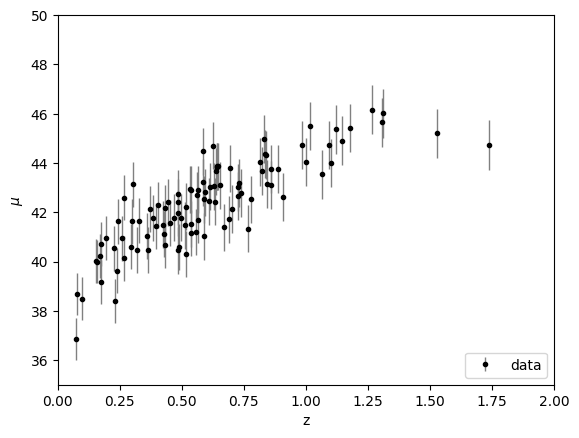

In [2]:
from astroML.datasets import generate_mu_z
z_sample, mu_sample, dmu = generate_mu_z(100, random_state=1234) # YOU CANNOT CHANGE THIS

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel("z")
plt.ylabel(r"$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)

# Part 2

**Fit with GPR - Kernel RBF**

The RBF kernel is defined by $k(x_i, x_j) = \exp\left(- \frac{d(x_i, x_j)^2}{2l^2} \right)$.

In [3]:
from sklearn.gaussian_process import GaussianProcessRegressor, kernels

X = z_sample[:,np.newaxis]
y = mu_sample
kernel1 = kernels.RBF(1/0.5, (1/0.5, 1/0.5))  # I pass the length scale and the length scale bounds
gp = GaussianProcessRegressor(kernel=kernel1, alpha=(dmu) ** 2, optimizer=None)
# If I don't add optimizer=None, an error 'status' is returned
gp.fit(X,y)
y_pred, dy_pred = gp.predict(X, return_std=True)

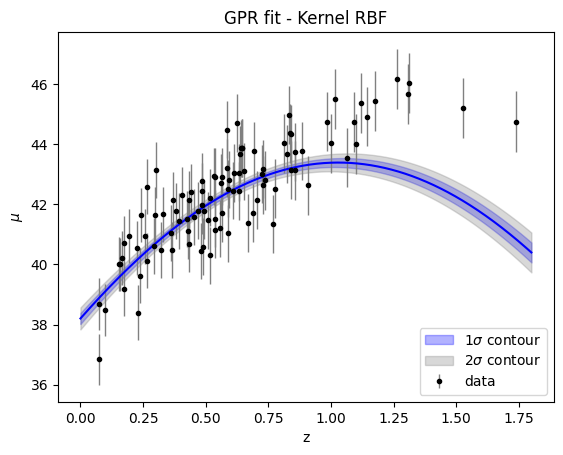

In [4]:
x = np.linspace(0, 1.8, 1000)
mu_pred, dmu_pred = gp.predict(x[:,np.newaxis], return_std=True)

# I plot the constrained function with errors
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel("z")
plt.ylabel(r"$\mu$")
plt.legend(loc='lower right')
plt.plot(x, mu_pred, '-', color='blue')
plt.fill_between(x, mu_pred - dmu_pred, mu_pred + dmu_pred, color='blue', alpha=0.3, label='1$\sigma$ contour')
plt.fill_between(x, mu_pred - 2*dmu_pred, mu_pred + 2*dmu_pred, color='gray', alpha=0.3, label='2$\sigma$ contour')
plt.title('GPR fit - Kernel RBF')
plt.legend(loc='lower right')
plt.show()

I am not satisfied by this result (the data on the right are very far from the expectation value given by the fit). I need to try with another kernel: this time I use a RBF kernel multiplied by a constant kernel.

**Fit with GPR - RBF x Constant kernel**

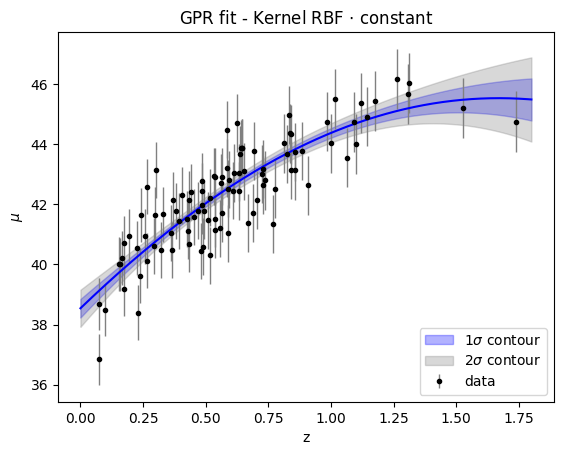

In [5]:
X = z_sample[:,np.newaxis]
y = mu_sample
kernel2 = kernels.ConstantKernel(10, (1e-3, 1e3))*kernels.RBF(3.0, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel2, alpha=(dmu) ** 2)
gp.fit(X,y)
y_pred, dy_pred = gp.predict(X, return_std=True)

mu_pred, dmu_pred = gp.predict(x[:,np.newaxis], return_std=True)

# I plot the constrained function with errors
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel("z")
plt.ylabel(r"$\mu$")
plt.plot(x, mu_pred, '-', color='blue')
plt.fill_between(x, mu_pred - dmu_pred, mu_pred + dmu_pred, color='blue', alpha=0.3, label='1$\sigma$ contour')
plt.fill_between(x, mu_pred - 2*dmu_pred, mu_pred + 2*dmu_pred, color='gray', alpha=0.3, label='2$\sigma$ contour')
plt.title('GPR fit - Kernel RBF $\cdot$ constant')
plt.legend(loc='lower right')
plt.show()

I've obtained a vey good fit of the data. I notice that the uncertainties are smaller in the region where there are more data (on the left), while the uncertainty rises for high z.

**Cloning**

Firstly I estimate the density of the dataset with a KDE. Then I sample z values from the density estimator and I predict the $mu$ values thanks to the Gaussian Process Regressor.

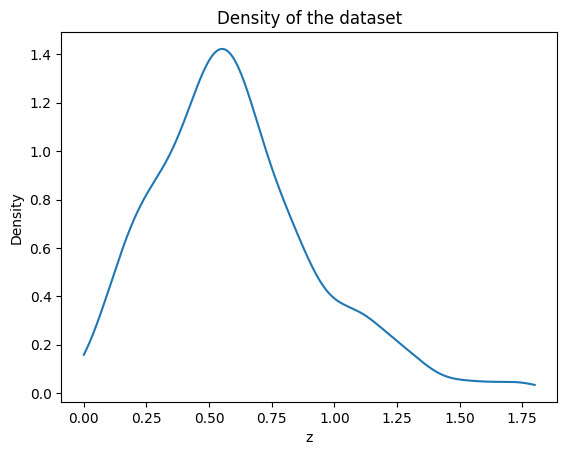

In [6]:
# density of the dataset
from sklearn.neighbors import KernelDensity

kde = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(X)
log_dens = kde.score_samples(x[:,np.newaxis])
density = np.exp(log_dens)

plt.plot(x, density)
plt.xlabel('z')
plt.ylabel('Density')
plt.title('Density of the dataset')
plt.show()

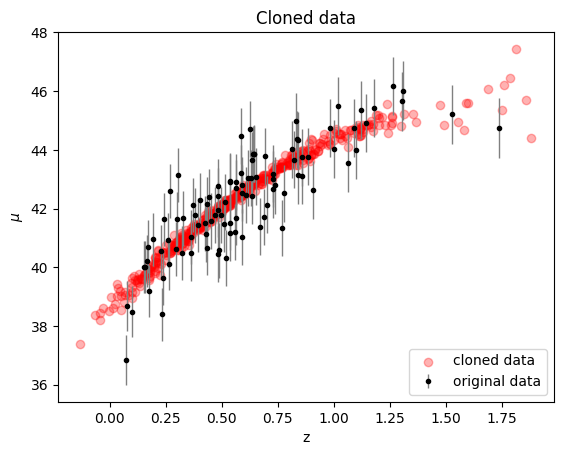

In [7]:
# I generate new z taking into account the density of the dataset
N = 500
new_z_samples = kde.sample(N)
# new_z_samples has already shape (N, 1)

# I generate new mu values using the GPR fit
mu_new_pred, sigma_new_pred = gp.predict(new_z_samples, return_std=True)

# I add realistic noise to mu
mu_simulated = np.random.normal(mu_new_pred, sigma_new_pred)

# I plot the result
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1, label='original data')
plt.scatter(new_z_samples, mu_simulated, color='red', alpha=0.3, label='cloned data')
plt.title('Cloned data')
plt.xlabel("z")
plt.ylabel(r"$\mu$")
plt.legend(loc='lower right')
plt.show()

# Part 3

The predicted relationship between the distance module $\mu$ and the redshift is

$\mu = 5 \log \left( \frac{c/H_0} {10 {\rm pc}}(1+z)\int_0^z \frac{dz'}{\sqrt{\Omega_m (1+z^3)+\Omega_\Lambda}} \right)$.

It's a a parametric non-linear model for $\mu(z)$ that depends on two parameters, the Hubble constant $H_0$ and the matter content of the Universe $\Omega_m$. I fit this model to the data using the nested sampling.


**Definition of the model**

In [8]:
import astropy.cosmology as cosmo

def model(z, H0, Om):
    cosmo_tmp = cosmo.LambdaCDM(H0=H0, Om0=Om, Ode0=1-Om)
    mu_model = cosmo_tmp.distmod(z).value
    return  mu_model

Om_theo = cosmo.Planck18.Om0
H0_theo = cosmo.Planck18.H0.value 
z_theory = np.linspace(0, 2.0, 1000)
mu_theory = model(z_theory, H0_theo, Om_theo)

c:\Users\marti\Anaconda\envs\astro\Lib\site-packages\astropy\cosmology\_src\flrw\base.py:1380: RuntimeWarning: divide by zero encountered in log10
  val = 5.0 * np.log10(abs(self.luminosity_distance(z).value)) + 25.0


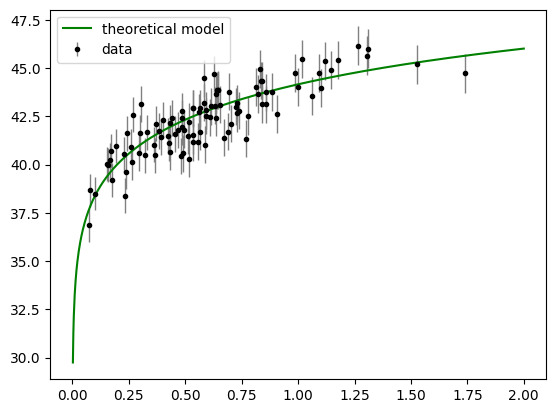

In [9]:
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.plot(z_theory, mu_theory, color='green', label = 'theoretical model')
plt.legend()
plt.show()

**Nested Sampling**

In [11]:
import dynesty

# Note on the prior function: in nested sampling the prior parameters are drawn from a $[0,1]^d$ space,
# so I need to choose a prior function that defines how to transform a parameter from the normalized space to the original space

# para = [H_0, O_m]

def prior_uniform(u):       
    H0_min, H0_max = 50, 100
    Om_min, Om_max = 0.1, 1
    H0 = st.uniform(loc=H0_min,scale=H0_max-H0_min).ppf(u[0])
    Om = st.uniform(loc=Om_min,scale=Om_max-Om_min).ppf(u[1])
    return H0, Om

def ln_likelihood(par, z_sample, mu_sample, dmu):
    H0, Om = par    
    if Om < 0:
        return -np.inf
    else:
        mu_model = model(z_sample, H0, Om)
    return -0.5 * np.sum((mu_sample-mu_model)**2/(dmu**2) + np.log(2*np.pi*dmu**2))

In [12]:
ndim = 2   # number of parameters in the model
sampler_DE = dynesty.NestedSampler(ln_likelihood, prior_uniform, ndim, logl_args=[z_sample, mu_sample, dmu])
sampler_DE.run_nested()
results_DE = sampler_DE.results
print('done')

iter: 1484 | +500 | bound: 0 | nc: 1 | ncall: 10555 | eff(%): 19.731 | loglstar:   -inf < -132.814 <    inf | logz: -134.923 +/-  0.039 | dlogz:  0.001 >  0.509                                      

done


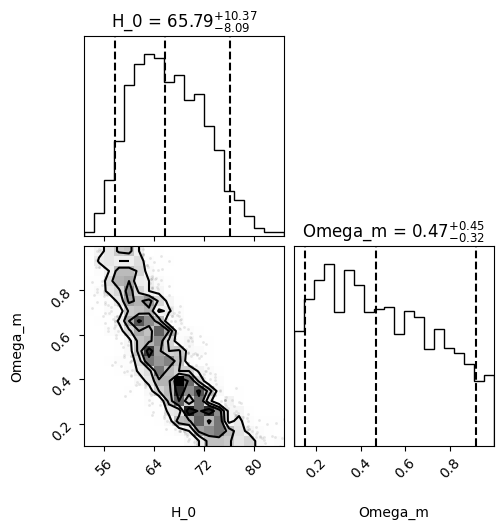

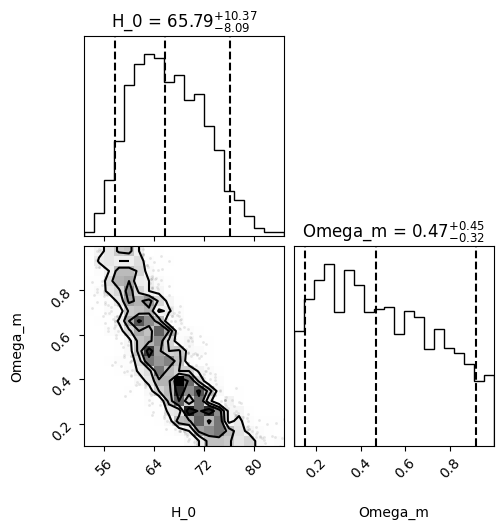

In [14]:
import corner
from dynesty import utils as dyfunc

samples = results_DE.samples  # samples
weights = np.exp(results_DE.logwt - results_DE.logz[-1])  # normalized weights
# logwt = the log_weight (unnormalized) associated with each sample
# logz = the cumulative evidence at each iteration (sample): the final evidence is the last element of logz

labels = ["H_0","Omega_m"]

samples_equal = dyfunc.resample_equal(samples, weights)
corner.corner(samples_equal, labels=labels, show_titles=True, quantiles=[0.05, 0.5, 0.95])

I can compare my results with a model without dark energy. I perform nested sampling on this new model, where the only parameter is now $H_0$.

In [24]:
def model_NoDE(z, H0):
    cosmo_tmp = cosmo.LambdaCDM(H0=H0, Om0=1, Ode0=0)
    mu_model = cosmo_tmp.distmod(z).value
    return  mu_model

def prior_uniform_NoDE(u):       
    H0_min, H0_max = 50, 100
    H0 = st.uniform(loc=H0_min,scale=H0_max-H0_min).ppf(u[0])
    return np.array([H0])

def ln_likelihood_NoDE(par, z_sample, mu_sample, dmu):
    H0 = par[0]
    mu_model = model_NoDE(z_sample, H0)
    return -0.5 * np.sum((mu_sample-mu_model)**2/(dmu**2) + np.log(2*np.pi*dmu**2))

In [25]:
ndim = 1    # number of parameters in the model
sampler_NoDE = dynesty.NestedSampler(ln_likelihood_NoDE, prior_uniform_NoDE, ndim, logl_args=[z_sample, mu_sample, dmu], nlive=1000)
sampler_NoDE.run_nested()
results_NoDE = sampler_NoDE.results
print('done')

iter: 2490 | +1000 | bound: 0 | nc: 1 | ncall: 12186 | eff(%): 31.200 | loglstar:   -inf < -133.530 <    inf | logz: -135.637 +/-    nan | dlogz:  0.001 >  1.009                                     

done


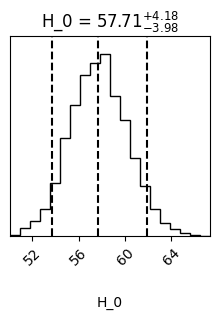

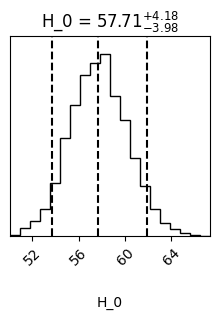

In [26]:
samples = results_NoDE.samples  # samples
weights = np.exp(results_NoDE.logwt - results_NoDE.logz[-1])  # normalized weights
# logwt = the log_weight (unnormalized) associated with each sample
# logz = the cumulative evidence at each iteration (sample): the final evidence is the last element of logz

labels = ["H_0"]

samples_equal = dyfunc.resample_equal(samples, weights)
corner.corner(samples_equal, labels=labels, show_titles=True, quantiles=[0.05, 0.5, 0.95])

I compute the Bayes factor between the two models, which is the ratio between the evidence of the two models.

In [27]:
# With DE
# Extract sampling results
sample = results_DE.samples  # samples
weights = np.exp(results_DE.logwt - results_DE.logz[-1])  # normalized weights

evidence = results_DE.logz[-1] #evidence
print("With DE, Bayesian evidence", np.exp(evidence))

# No DE
# Extract sampling results
samples_new = results_NoDE.samples  # samples
weights_new = np.exp(results_NoDE.logwt - results_NoDE.logz[-1])  # normalized weights

evidence_new = results_NoDE.logz[-1] #evidence
print("No DE, Bayesian evidence", np.exp(evidence_new))

# Bayes factor
bayes_factor = np.exp(evidence) / np.exp(evidence_new)
print('The Bayes factor between the two models is B = %.2f' %bayes_factor)

With DE, Bayesian evidence 2.5333487730235317e-59
No DE, Bayesian evidence 1.240327312182863e-59
The Bayes factor between the two models is B = 2.04


The Bayes factor is inconclusive, I can't select the best model.